In [12]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

def load_file(data_dir='../data/action_hourly'):
    p = Path(data_dir)
    files = p.glob('*/*.tsv')
    df_lis =[]
    for file in files:
        tmp_df = pd.read_csv(file, delimiter='\t',encoding='utf-8')
        df_lis.append(tmp_df)
    return pd.concat(df_lis, ignore_index=True)

def format_df(df):
    df.drop(['app_name'], axis=1, inplace=True)
    df['log_date'] = df['log_date'].apply(lambda x: int(x[-2:]))
    return df

def sort_df(df):
    df = df.iloc[:,[2,0,1,3]]
    df = df.sort_values(['user_id','log_date','log_hour'])
    return df.reset_index(drop=True)

def df_train_test_split(df, day):
    df_train = df[df['log_date'] < day]
    df_test  = df[df['log_date'] >= day]
    return df_train, df_test

def make_XandY(df):
    '''If you write processing in this function by not df but df.values(np.array),
       the speed would be much faseter.
       But that reduces readability and so on, I didn't.'''

    def make_X(df_user,date):
        x_arr = np.zeros(24)
        for row in df_user[df_user['log_date'] == date].iterrows():
            row = row[1]
            x_arr[row['log_hour']] = row['count']
        return x_arr

    def make_Y(df_user, date):
        df_user_date = df_user[df_user['log_date'] == date]
        y_arr = np.zeros(24)
        for hour in df_user_date['log_hour'].unique():
            y_arr[hour] = 1
        return y_arr

    x_lis = []
    y_lis = []
    for user in df['user_id'].unique():
        df_user = df[df['user_id'] == user]
        for date in df_user['log_date'].unique():
            x_lis.append(make_X(df_user, date))
            y_lis.append(make_Y(df_user, date+1))
    return np.array(x_lis), np.array(y_lis)

def fit_all(rfc_lis, X, Y):
    for hour, rfc in enumerate(rfc_lis):
        rfc.fit(X, Y[:,hour])

def score_all(rfc_lis, X, Y):
    for hour, rfc in enumerate(rfc_lis):
        yield rfc.score(X, Y[:,hour])

def plot_24bar(Y, title, ylim=(0,0.2), xlabel='hour', ylabel='feature importances'):
    left = np.arange(24)
    labels_am = [str(hour) + 'am' for hour in range(12)]
    labels_pm = [str(hour) + 'pm' for hour in range(12)]
    labels = labels_am + labels_pm
    fig = plt.figure(figsize=(15,5),dpi=70)
    ax = fig.add_subplot(1,1,1)
    ax.bar(left, Y, tick_label=labels, align='center')
    for x, y in zip(left, Y):
        ax.text(x, y, f'{y:.3f}', ha='center', va='bottom')
    ax.set_ylim(ylim)
    ax.grid(True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

In [13]:
# make model
split_day = int(31*0.7)

df = load_file()
df = format_df(df)
df = sort_df(df)
df_train, df_test = df_train_test_split(df, split_day)
X_train, Y_train = make_XandY(df_train) # this process take a few seconds.
X_test,  Y_test  = make_XandY(df_test)  # this process take a few seconds.
rfc_lis = [RandomForestClassifier(random_state=0, n_estimators=20) for hour in range(24)]
fit_all(rfc_lis, X_train, Y_train) # this process take a few seconds.

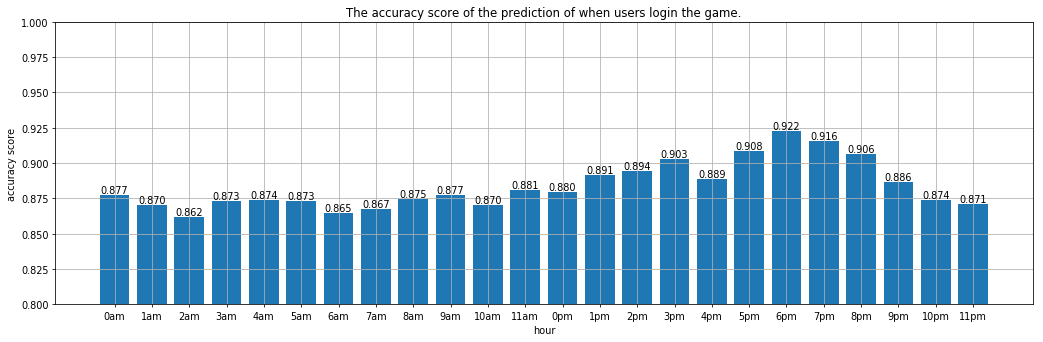

In [14]:
# show result
score_lis = list(score_all(rfc_lis, X_test, Y_test))
plot_24bar(Y=score_lis,
           title='The accuracy score of the prediction of when users login the game.',
           ylim=(0.8,1),
           xlabel='hour',
           ylabel='accuracy score')

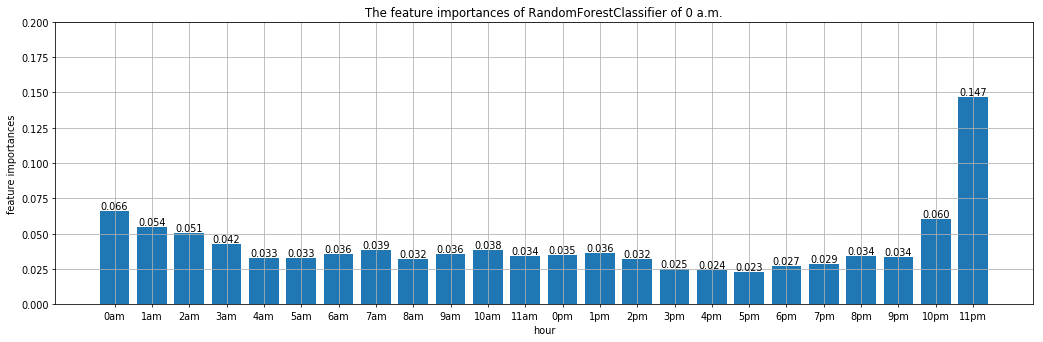

In [15]:
# As examplel, look the feature importances of RFC of 0 am
rfc0_feature_importances = rfc_lis[0].feature_importances_
plot_24bar(rfc0_feature_importances,
           title='The feature importances of RandomForestClassifier of 0 a.m.')

# The reason why the value of 11pm is much higher than that of others is that
# users who play the game at 11pm are likely to continue to play, even though the date changes.